# PHYS-E0412 Computational Physics :: Homework 10
Ari Viitala 432568

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import coo_matrix, eye, diags, csr_matrix
import scipy
from scipy.sparse.linalg import spsolve, inv, spsolve_triangular

In [2]:
def sten(N):
    D = 4 * np.diag(np.ones(N)) - np.diag(np.ones(N-1), k = -1) - np.diag(np.ones(N-1), k = 1) 
    
    #boundary conditions
    D[0] = D[-1] = 0
    D[0,0] = D[-1,-1] = 1
    
    #identity matrix for off diagonals
    I = np.diag(np.ones(N))
    IO = np.copy(I)
    
    #boundary conditions
    IO[0] = IO[-1] = 0
    
    s = np.diag(np.zeros(N**2))
    
    #filling the stencil with block matrices
    for i in range(0, N):
            if i == 0:
                #first row
                s[:N,0:N] = I
            elif i == N - 1:
                #last row
                s[i*N:,N*i:] = I
            else:
                #other rows
                s[i*N:(i+1)*N,N*(i-1):N*(i+2)] = np.hstack((-IO,D,-IO))
    
    #scaling
    s *= 1 / (1 / (N-1)**2)
    s += 2*np.eye(N*N)
    return s

In [3]:
def sparse_sten(Nx):
    j = 0
    nnz= 5 * (Nx - 2) * (Nx - 2) + 2 * Nx + 2 * (Nx - 2); 
    
    vals = np.zeros((nnz))
    rows = np.zeros((nnz), dtype = int)
    cols = np.zeros((nnz), dtype = int)
    
    
    for row in range(Nx*Nx):
    
        if(row < Nx):
            vals[j] = 1
            cols[j] = row
            rows[j] = row
            j+=1
        elif(row < Nx*Nx - Nx):
            if (row % Nx == 0 or row % Nx == Nx - 1):
                vals[j] = 1;
                cols[j] = row;
                rows[j] = row;
                j += 1;
            else:
                vals[j] = -1;
                cols[j] = row - Nx;
                rows[j] = row;

                vals[j + 1] = -1;
                cols[j + 1] = row - 1;
                rows[j + 1] = row;

                vals[j + 2] = 4;
                cols[j + 2] = row;
                rows[j + 2] = row;

                vals[j + 3] = -1;
                cols[j + 3] = row + 1;
                rows[j + 3] = row;

                vals[j + 4] = -1;
                cols[j + 4] = row + Nx;
                rows[j + 4] = row;
                j += 5;
        else:
            vals[j] = 1;
            cols[j] = row;
            rows[j] = row;
            j += 1;
    #plt.plot(cols)
    #plt.plot(rows)
    coo =  1 / (1 / (Nx-1)**2) * coo_matrix((vals, (rows, cols)))
    coo += 2*eye(Nx*Nx)
    return  coo.tocsr()

In [4]:
def sym_sparse_sten(Nx):
    j = 0
    nd = 3 * (Nx) - 2
    
    nnz = Nx * nd + 2 * (Nx - 1) * Nx
    
    vals = np.zeros((nnz))
    rows = np.zeros((nnz), dtype = int)
    cols = np.zeros((nnz), dtype = int)
    
    
    for row in range(Nx*Nx):
        if(row < Nx):
            if (row % Nx == 0):
                vals[j] = 4
                cols[j] = row
                rows[j] = row
                
                vals[j + 1] = -1
                cols[j + 1] = row + 1
                rows[j + 1] = row
                
                vals[j + 2] = -1
                cols[j + 2] = row + Nx
                rows[j + 2] = row
                                
                j += 3
                
                
            elif(row % Nx == Nx - 1):
                vals[j] = -1
                cols[j] = row - 1
                rows[j] = row
                
                vals[j + 1] = 4
                cols[j + 1] = row
                rows[j + 1] = row
                
                vals[j + 2] = -1
                cols[j + 2] = row + Nx
                rows[j + 2] = row
                
                j += 3
                
            else:
                vals[j] = -1
                cols[j] = row - 1
                rows[j] = row
                
                vals[j + 1] = 4
                cols[j + 1] = row
                rows[j + 1] = row
                
                vals[j + 2] = -1
                cols[j + 2] = row + 1
                rows[j + 2] = row
                
                vals[j + 3] = -1
                cols[j + 3] = row + Nx
                rows[j + 3] = row
                
                j += 4
                
        elif(row > Nx * Nx - Nx -1):
            if (row % Nx == 0):
                vals[j] = -1
                cols[j] = row - Nx
                rows[j] = row
                
                vals[j + 1] = 4
                cols[j + 1] = row
                rows[j + 1] = row
                
                vals[j + 2] = -1
                cols[j + 2] = row + 1
                rows[j + 2] = row   
                                
                j += 3
                
                
            elif(row % Nx == Nx - 1):
                vals[j] = -1
                cols[j] = row - Nx
                rows[j] = row
                
                vals[j + 1] = -1
                cols[j + 1] = row - 1
                rows[j + 1] = row
                
                vals[j + 2] = 4
                cols[j + 2] = row
                rows[j + 2] = row
                
                j += 3
                
            else:
                vals[j] = -1
                cols[j] = row - 1
                rows[j] = row
                
                vals[j + 1] = 4
                cols[j + 1] = row
                rows[j + 1] = row
                
                vals[j + 2] = -1
                cols[j + 2] = row + 1
                rows[j + 2] = row
                
                vals[j + 3] = -1
                cols[j + 3] = row - Nx
                rows[j + 3] = row
                
                j += 4
        
        else:
            if (row % Nx == 0):
                vals[j] = -1
                cols[j] = row - Nx
                rows[j] = row
                
                vals[j + 1] = -1
                cols[j + 1] = row + 1
                rows[j + 1] = row
                
                vals[j + 2] = 4
                cols[j + 2] = row
                rows[j + 2] = row
                
                vals[j + 3] = -1
                cols[j + 3] = row + Nx
                rows[j + 3] = row    
                
                j += 4
                
                
            elif(row % Nx == Nx - 1):
                vals[j] = -1
                cols[j] = row - Nx
                rows[j] = row
                
                vals[j + 1] = 4
                cols[j + 1] = row
                rows[j + 1] = row
                
                vals[j + 2] = -1
                cols[j + 2] = row - 1
                rows[j + 2] = row
                
                vals[j + 3] = -1
                cols[j + 3] = row + Nx
                rows[j + 3] = row
                
                
                j += 4
                
            else:   
                vals[j] = -1;
                cols[j] = row - Nx;
                rows[j] = row;

                vals[j + 1] = -1;
                cols[j + 1] = row - 1;
                rows[j + 1] = row;

                vals[j + 2] = 4;
                cols[j + 2] = row;
                rows[j + 2] = row;

                vals[j + 3] = -1;
                cols[j + 3] = row + 1;
                rows[j + 3] = row;

                vals[j + 4] = -1;
                cols[j + 4] = row + Nx;
                rows[j + 4] = row;
                
                j += 5;


    #plt.plot(cols)
    #plt.plot(rows)
    #plt.plot(vals)
    coo =  1 / (1 / (Nx-1)**2) * coo_matrix((vals, (rows, cols)))
    coo += 2*eye(Nx*Nx)
    return  coo.tocsr()

In [5]:
def conjugate(A, b, iters):
    N = len(b)
    x = np.zeros(N)
    P = np.eye(N)
    r = b - np.dot(A, x)
    z = np.linalg.solve(P, r)
    p = z
    
    tol = 1e-6
    
    k = 0
    
    res = []
    
    for i in range(iters):
        print(i)
        res.append(np.linalg.norm(r))
        
        alpha = np.dot(r, r) / np.dot(np.dot(p, A), p)
        
        x = x + alpha * p
        r1 = r - alpha * np.dot(A, p)
        
        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            break
        
        beta = np.dot(r1.T, r1) / np.dot(r.T, r)
        
        p = r1 + beta * p
        r = r1
        
    return i, res, x.reshape((int(np.sqrt(N)),int(np.sqrt(N))))

In [6]:
def vec_b(N):
    b = np.zeros((N,N))
    x = y = np.linspace(0,1,N)
    
    #calcultaing the values
    for i in range(N):
        for j in range(N):
            b[i, j] = np.exp(-((x[i] - 0.5)**2 + (y[j]-0.5)**2) / 10)
                             
    #boundary conditions
    b[0,:] = 0
    b[:,0] = 0
    b[-1,:] = 0
    b[:,-1] = 0
                             
    #flatten the matrix for 1-d array
    return b.flatten()

In [7]:
def sym_vec_b(N):
    b = np.zeros((N,N))
    x = y = np.linspace(0,1,N)
    
    #calcultaing the values
    for i in range(N):
        for j in range(N):
            b[i, j] = np.exp(-((x[i] - 0.5)**2 + (y[j]-0.5)**2) / 10)
    
    return b.flatten()

In [8]:
def sparse_conjugate(A, b, iP, iters):
    N = len(b)
    x = np.zeros(N)
    r = b - A.dot(x)
    z = iP.dot(r)
    p = z.copy()
    
    tol = 1e-6
    
    res = []
    
    for i in range(iters):
        #print(i)
        
        res.append(np.linalg.norm(r))
        #print(p.dot(A.dot(p)))
        alpha = r.dot(z) / (p.dot(A.dot(p)))
        #alpha = np.dot(r.T, r) / p.T.dot(A.dot(p))
        
        x1 = x + alpha * p
    
        r1 = r - alpha * A.dot(p)
        
        
        if np.linalg.norm(r1) / np.linalg.norm(b) < tol:
            break
        
    
        z1 = iP.dot(r1)
        
        beta = r1.dot(z1) / r.dot(z)
        #beta = np.dot(r1.T, r1) / np.dot(r.T, r)
        
        p = z1 + beta * p
        #p = r1 + beta * p
        
        r = r1
        x = x1
        z = z1
        
    return i, res, x.reshape((int(np.sqrt(N)),int(np.sqrt(N))))

In [9]:
N = 100

A = sym_sparse_sten(N)
b = sym_vec_b(N)
iters = 200
P = eye(N*N).tocsc()

i, res, sx = sparse_conjugate(A, b, P, iters)

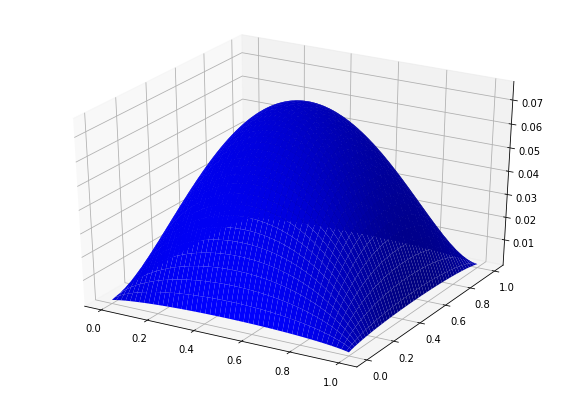

In [10]:
fig = plt.figure(1, (10, 7))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(np.linspace(0,1,N), np.linspace(0, 1, N))
# Plot the surface
ax.plot_surface(X, Y, sx, color='b')

plt.show()

In [11]:
N = 100
A = sym_sparse_sten(N)
b = sym_vec_b(N)

P_reg = eye(N*N)

P_diag = diags(A.diagonal()).tocsc().power(-1)

P1 = scipy.sparse.tril(A).tocsr()
P2 = scipy.sparse.triu(A).tocsr()

P1i = scipy.sparse.linalg.spsolve_triangular(P1, np.eye(N*N))
P2i = scipy.sparse.linalg.spsolve_triangular(P2, np.eye(N*N), lower = False)

P_triag = P2i.dot(P1i)

In [12]:
N = 100
A = sym_sparse_sten(N)
b = sym_vec_b(N)

L = np.linalg.cholesky(A.todense())    
    
L[A.todense() == 0] = 0

L = csr_matrix(L)

Li = scipy.sparse.linalg.spsolve_triangular(L, np.eye(N*N))
LTi = scipy.sparse.linalg.spsolve_triangular(L.T, np.eye(N*N), lower = False)

P_chol =csr_matrix(Li.dot(LTi))

/home/ari/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:496: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  SparseEfficiencyWarning)


In [13]:
i,  res,  x = sparse_conjugate(A, b, P_reg,  iters)
di, dres, dx = sparse_conjugate(A, b, P_diag, iters)
ti, tres, tx = sparse_conjugate(A, b, P_triag, iters)
ci, cres, cx = sparse_conjugate(A, b, P_chol, iters)

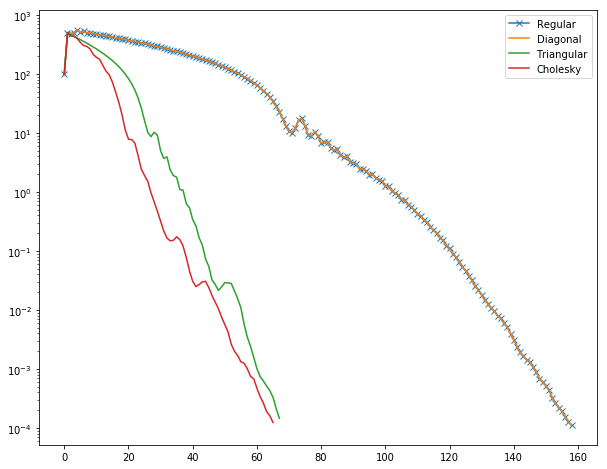

In [15]:
plt.figure(1, (10, 8))
plt.semilogy(res, label = "Regular", marker = "x")
plt.semilogy(dres, label = "Diagonal")
plt.semilogy(tres, label = "Triangular")
plt.semilogy(cres, label = "Cholesky")
plt.legend()
plt.show()

In [11]:
reg_conds = []
PD_conds = []
PT_conds = []
PC_conds = []

points = [10, 100, 500, 1000]

points = list(range(10, 100, 10))
for i in points:
    A = sym_sparse_sten(i)
    
    reg_e_max = scipy.sparse.linalg.eigs(A, k = 1, which="LR", return_eigenvectors=False)
    reg_e_min = scipy.sparse.linalg.eigs(A, k = 1, which="SR", return_eigenvectors=False)
      
    reg_conds.append(np.real(reg_e_max / reg_e_min))
    
    
    #Diagonal
    P = diags(sym_sparse_sten(i).diagonal()).tocsc().power(-1)
    PD = P.dot(A)
    
    pd_e_max = scipy.sparse.linalg.eigs(PD, k = 1, which="LR", return_eigenvectors=False)
    pd_e_min = scipy.sparse.linalg.eigs(PD, k = 1, which="SR", return_eigenvectors=False)
    
    PD_conds.append(np.real(pd_e_max / pd_e_min))
    
    
    #Triangular
    
    P1 = scipy.sparse.tril(A).tocsr()
    P2 = scipy.sparse.triu(A).tocsr()

    P1i = scipy.sparse.linalg.spsolve_triangular(P1, np.eye(i*i))
    P2i = scipy.sparse.linalg.spsolve_triangular(P2, np.eye(i*i), lower = False)

    P = P2i.dot(P1i)
    PT = A.dot(P)
     
    pt_e_max = scipy.sparse.linalg.eigs(PT, k = 1, which="LR", return_eigenvectors=False)
    pt_e_min = scipy.sparse.linalg.eigs(PT, k = 1, which="SR", return_eigenvectors=False)
    
    PT_conds.append(np.real(pt_e_max / pt_e_min))
    
    
    #Cholesky
    
    L = np.linalg.cholesky(A.todense())
    L[A.todense() == 0] = 0
    
    Li = scipy.sparse.linalg.spsolve_triangular(L, np.eye(i*i))
    
    PC = csr_matrix(Li.dot(Li.T))
    
    PC = PC.dot(A)
    
    c_e_max = scipy.sparse.linalg.eigs(PC, k = 1, which="LR", return_eigenvectors=False)
    c_e_min = scipy.sparse.linalg.eigs(PC, k = 1, which="SR", return_eigenvectors=False)
    
    PC_conds.append(np.real(c_e_max / c_e_min))
    
    print(i)
    

/home/ari/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:496: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  SparseEfficiencyWarning)


10
20
30
40
50
60
70
80
90


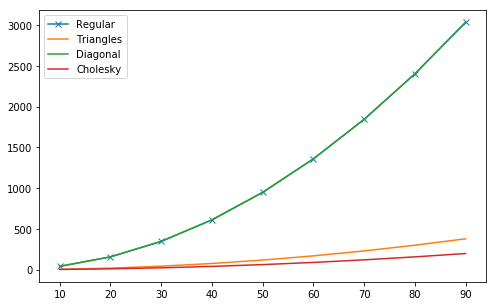

In [12]:
plt.figure(1, (8, 5))
plt.plot(points, reg_conds, label = "Regular", marker = "x")
plt.plot(points, PT_conds, label = "Triangles")
plt.plot(points, PD_conds, label = "Diagonal")
plt.plot(points, PC_conds, label = "Cholesky")

plt.legend(loc = 2)

In [9]:
reg_conds = []
reg_iters = []
PD_conds = []
PD_iters = []
PT_conds = []
PT_iters = []
PC_conds = []
PC_iters = []

points = [10, 50, 100, 250, 500, 1000]

points = list(range(10, 100, 10))

iters = 500

for i in points:
    A = sym_sparse_sten(i)
    b = sym_vec_b(i)
    
    #reg_e_max = scipy.sparse.linalg.eigs(A, k = 1, which="LR", return_eigenvectors=False)
    #reg_e_min = scipy.sparse.linalg.eigs(A, k = 1, which="SR", return_eigenvectors=False)
      
    #reg_conds.append(np.real(reg_e_max / reg_e_min))
    
    iP = eye(i*i)
    
    reg_i, reg_res, reg_x = sparse_conjugate(A, b, iP, iters)
    
    reg_iters.append(reg_i)
    
    #Diagonal
    
    PD = diags(sym_sparse_sten(i).diagonal()).tocsc().power(-1)

    #pd_e_max = scipy.sparse.linalg.eigs(PD, k = 1, which="LR", return_eigenvectors=False)
    #pd_e_min = scipy.sparse.linalg.eigs(PD, k = 1, which="SR", return_eigenvectors=False)
    
    #PD_conds.append(np.real(pd_e_max / pd_e_min))
    
    diag_i, diag_res, diag_x = sparse_conjugate(A, b, PD, iters)
    
    PD_iters.append(diag_i)
    
    #Triangular
    
    P1 = scipy.sparse.tril(A).tocsr()
    P2 = scipy.sparse.triu(A).tocsr()

    P1i = scipy.sparse.linalg.spsolve_triangular(P1, np.eye(i*i))
    P2i = scipy.sparse.linalg.spsolve_triangular(P2, np.eye(i*i), lower = False)

    PT = P2i.dot(P1i)
    
    #pt_e_max = scipy.sparse.linalg.eigs(PT, k = 1, which="LR", return_eigenvectors=False)
    #pt_e_min = scipy.sparse.linalg.eigs(PT, k = 1, which="SR", return_eigenvectors=False)
    
    #PT_conds.append(np.real(pt_e_max / pt_e_min))
    
    t_i, t_res, t_x = sparse_conjugate(A, b, PT, iters)
    
    PT_iters.append(t_i)
    
    
    #Cholesky
    
    L = np.linalg.cholesky(A.todense())
                       
    L[A.todense() == 0] = 0

    Li = scipy.sparse.linalg.spsolve_triangular(L, np.eye(i*i))
    LTi = scipy.sparse.linalg.spsolve_triangular(L.T, np.eye(i*i), lower = False)

    P_chol =csr_matrix(Li.dot(LTi))

    #c_e_max = scipy.sparse.linalg.eigs(PC, k = 1, which="LR", return_eigenvectors=False)
    #c_e_min = scipy.sparse.linalg.eigs(PC, k = 1, which="SR", return_eigenvectors=False)
    
    #PC_conds.append(np.real(c_e_max / c_e_min))
    
    c_i, c_res, c_x = sparse_conjugate(A, b, P_chol, iters)
    
    PC_iters.append(c_i)
    
    print(i)
    

/home/ari/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:496: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  SparseEfficiencyWarning)


10
20
30
40
50
60
70
80
90


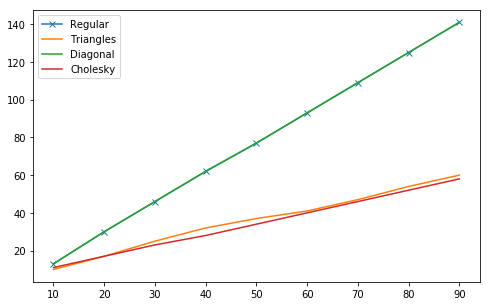

In [13]:
plt.figure(1, (8, 5))
plt.plot(points, reg_iters, label = "Regular", marker = "x")
plt.plot(points, PT_iters, label = "Triangles")
plt.plot(points, PD_iters, label = "Diagonal")
plt.plot(points, PC_iters, label = "Cholesky")

plt.legend(loc = 2)